In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

In [2]:
runtime_cov_df = df.groupby( ['provider'])['runtime'].apply(utils.cov).dropna().reset_index(name='Runtime CV').set_index(['provider'])
resp_df = df.groupby( ['provider', 'driver_invocation']).size().reset_index(name='counts')

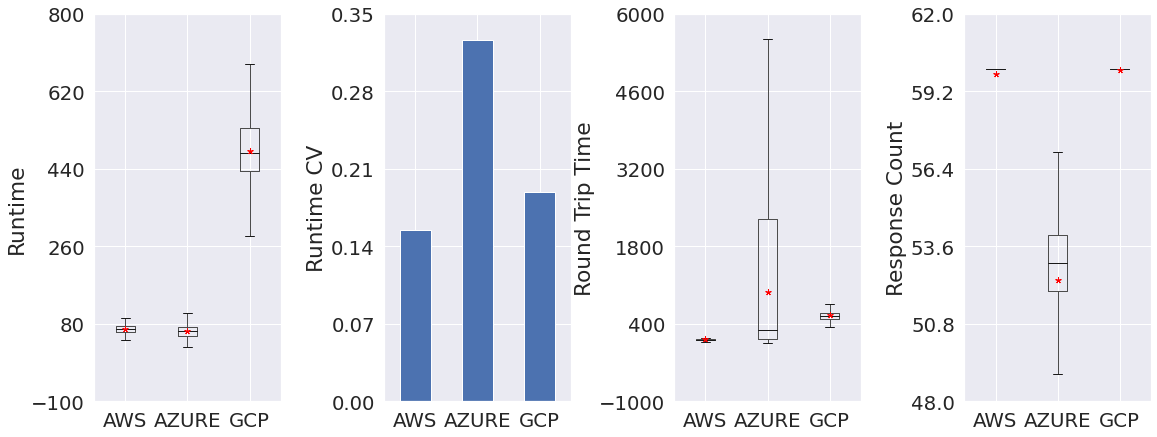

data 
            runtime                                                             \
             count        mean        std    min    25%    50%    75%     max   
provider                                                                        
AWS       173566.0   69.073206  10.714942   31.0   62.0   67.0   75.0   567.0   
AZURE     151962.0   62.751780  20.487580   26.0   51.0   64.0   73.0  4066.0   
GCP       174008.0  481.566261  91.113365  130.0  434.0  476.0  534.0  4290.0   

         roundTripTime                                                    \
                 count        mean          std     min     25%      50%   
provider                                                                   
AWS           173566.0  124.796232   551.590142   68.77   99.82  108.860   
AZURE         151962.0  972.913213  1200.538127   60.40  121.14  282.545   
GCP           174008.0  566.612940   195.953561  210.82  496.00  536.680   

                             
              75%  

In [3]:
sns.set(font_scale=1.8)

# Plot Coefficient Of Variation Per Cloud Provider:
fig, axes = plt.subplots(figsize=(16,6), ncols=4, nrows=1, frameon=False, sharex=True)
max_nticks = 6

runtime_bx_ax = axes[0]
runtime_cov_ax = axes[1]
roundtrip_bx_ax = axes[2]
respcount_bx_ax = axes[3]

# Runtime COV
runtime_cov_df.plot(kind='bar', ax=runtime_cov_ax)
runtime_cov_ax.set_xlabel('')
runtime_cov_ax.set_ylabel('Runtime CV')
runtime_cov_ax.get_legend().remove()
plt.setp(runtime_cov_ax.get_xticklabels(), rotation=0)

ax = runtime_cov_ax
ax.set_ylim(min(ax.get_yticks()), max(ax.get_yticks()))
ax.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(max_nticks))

# Boxplot Runtime
df_boxplot = df[['provider', 'runtime']].sort_values(by=['provider']).groupby(['provider'], observed=True)
utils.boxplot(runtime_bx_ax, df_boxplot, 'Runtime', utils.tick_get_1st, with_mean=True, nticks=max_nticks)

df_boxplot = df[['provider', 'roundTripTime']].sort_values(by=['provider']).groupby(['provider'], observed=True)
utils.boxplot(roundtrip_bx_ax, df_boxplot, 'Round Trip Time', utils.tick_get_1st, with_mean=True, nticks=max_nticks)

df_boxplot = resp_df[['provider', 'counts']].sort_values(by=['provider']).groupby(['provider'], observed=True)
ax = utils.boxplot(respcount_bx_ax, df_boxplot, 'Response Count', utils.tick_get_1st, with_mean=True, nticks=max_nticks)

fig.tight_layout(pad=0.2)

data = df[['provider', 'runtime', 'roundTripTime']].groupby(['provider'], observed=True).describe()
utils.plot(['provider_analysis', 'pa_provider_mean_cov'], 
            data=data,
            respdata=resp_df.groupby(['provider']).describe(),
            runtime_cv=runtime_cov_df.groupby(['provider']).describe()
          )

In [4]:
rtt_cov_df = df.groupby( ['provider'], observed=True)['roundTripTime'].apply(utils.cov).dropna().reset_index(name='Round Trip Time CV').set_index(['provider'])
rtt_cov_df

,Round Trip Time CV
provider,
AWS,4.419926
AZURE,1.233962
GCP,0.345833


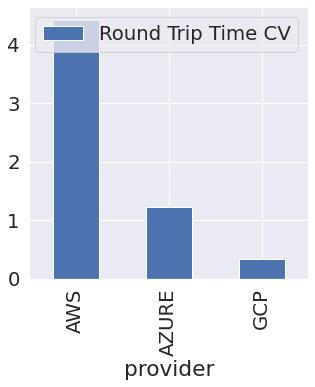

In [5]:
rtt_cov_df.groupby('provider')
fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = rtt_cov_df.reset_index().groupby(['provider'])
rtt_cov_df.plot.bar(ax=axes)

utils.savefig(fig, ['provider_analysis', f'rtt_cv_boxplot'], data=rtt_cov_df)